# **Facial analysis for predicting age, gender and ethnicity**

we use UTK face dataset for this project
https://www.kaggle.com/datasets/jangedoo/utkface-new/data

In [16]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sb
import os
import matplotlib.image as mpimg
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, MaxPool2D , Activation , BatchNormalization , GlobalAveragePooling2D , Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50, ResNet101, EfficientNetB0, EfficientNetB1, EfficientNetB4, EfficientNetB5, InceptionV3, Xception, DenseNet121, VGG16
import warnings
from tensorflow.keras.callbacks import ModelCheckpoint
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from IPython.display import display
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
import random
from gc import collect

In [99]:
os.listdir('/kaggle/input/utkface-new')

['UTKFace', 'utkface_aligned_cropped', 'crop_part1']

we use 'UTKFace' for train and validation and 'crop_part1' for test cases

In [100]:
image_data = os.listdir('/kaggle/input/utkface-new/UTKFace')
df = pd.DataFrame(image_data,columns=['image_data'])
df['image_data'] = df['image_data'].astype('string')
df[['age','gender','ethnicity','date']] = df['image_data'].str.split('_',expand=True)

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23708 entries, 0 to 23707
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_data  23708 non-null  string
 1   age         23708 non-null  string
 2   gender      23708 non-null  string
 3   ethnicity   23708 non-null  string
 4   date        23705 non-null  string
dtypes: string(5)
memory usage: 926.2 KB


In [102]:
values_to_remove = [
    '20170109142408075.jpg.chip.jpg',
    '20170109150557335.jpg.chip.jpg',
    '20170116174525125.jpg.chip.jpg'
]

df.drop(df[df['ethnicity'].isin(values_to_remove)].index, inplace=True)
df.drop(columns={'date'},inplace=True)

In [103]:
img_path = '/kaggle/input/utkface-new/UTKFace'
test_path = '/kaggle/input/utkface-new/crop_part1'

In [104]:
df

,image_data,age,gender,ethnicity
0,26_0_2_20170104023102422.jpg.chip.jpg,26,0,2
1,22_1_1_20170112233644761.jpg.chip.jpg,22,1,1
2,21_1_3_20170105003215901.jpg.chip.jpg,21,1,3
3,28_0_0_20170117180555824.jpg.chip.jpg,28,0,0
4,17_1_4_20170103222931966.jpg.chip.jpg,17,1,4
...,...,...,...,...
23703,41_0_0_20170109012220690.jpg.chip.jpg,41,0,0
23704,42_0_0_20170117185738076.jpg.chip.jpg,42,0,0
23705,2_0_2_20161219221701671.jpg.chip.jpg,2,0,2
23706,65_1_0_20170110182002744.jpg.chip.jpg,65,1,0


sample images

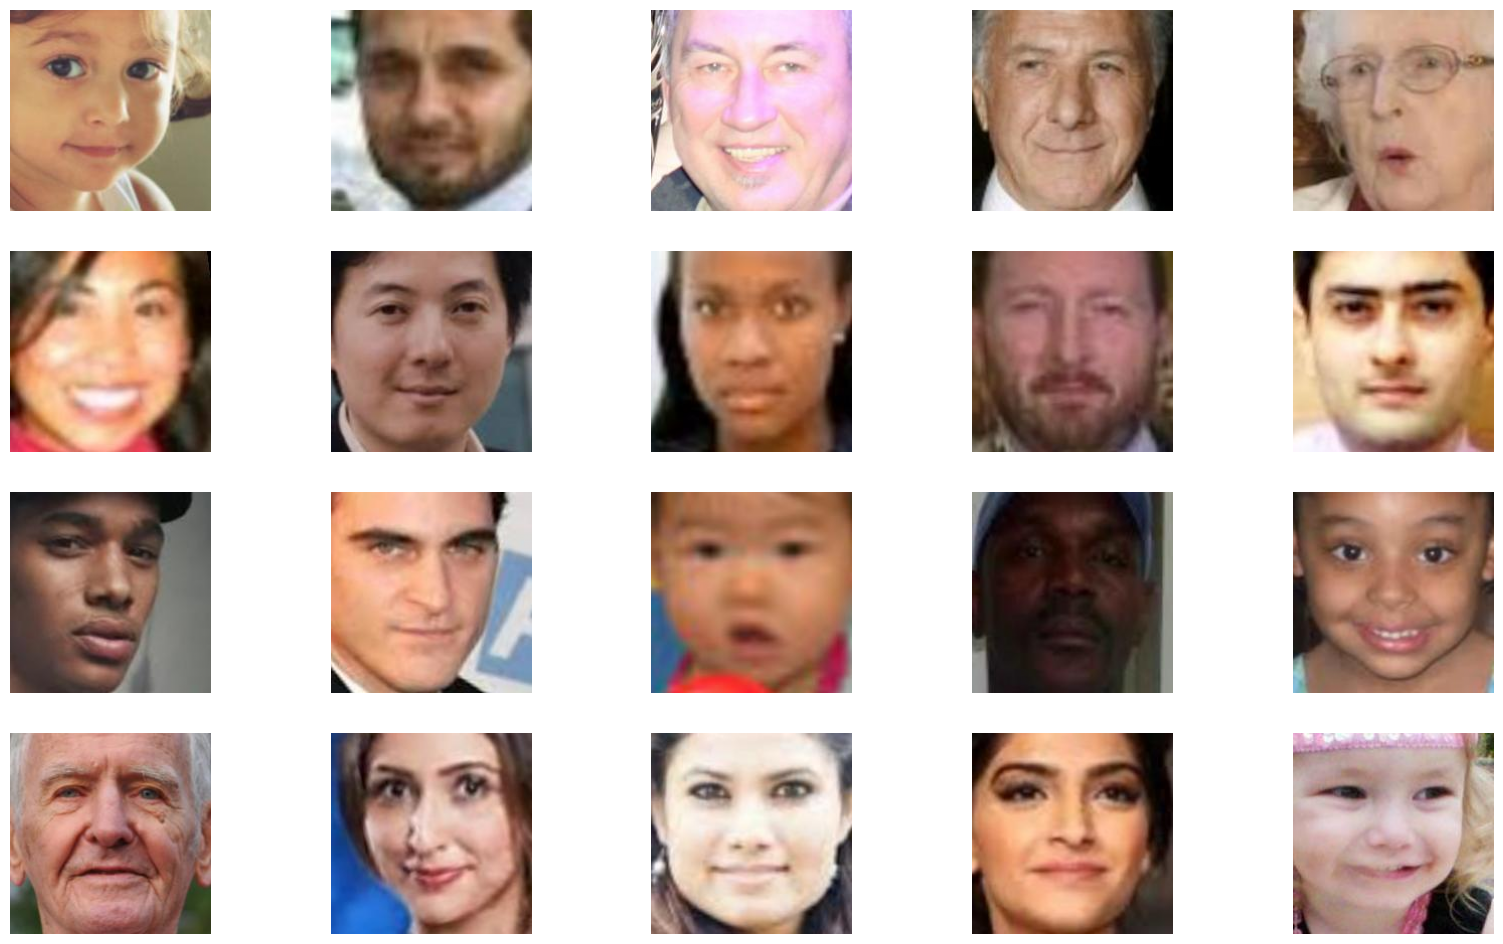

In [8]:
list_of_imgs = []
plt.figure(figsize=(20,12))
for i in range(20):
    random_img = random.choice(df['image_data'])
    img = mpimg.imread(f"/kaggle/input/utkface-new/UTKFace/{random_img}")
    plt.subplot(4,5,i+1)
    plt.imshow(img/255.)
    plt.axis(False)
plt.show()

In [9]:
X = []
for file in df['image_data']:
    img = load_img(f"/kaggle/input/utkface-new/UTKFace/{file}", target_size=(128,128))
    img_array = img_to_array(img) / 255
    X.append(img_array)

X = np.array(X)

In [10]:
df[['age', 'gender', 'ethnicity']] = df[['age', 'gender', 'ethnicity']].astype(int)

In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))

df['age'] = scaler.fit_transform(df[['age']])
print(df['age'])

0        0.217391
1        0.182609
2        0.173913
3        0.234783
4        0.139130
           ...   
23703    0.347826
23704    0.356522
23705    0.008696
23706    0.556522
23707    0.565217
Name: age, Length: 23705, dtype: float64


In [12]:
df

,image_data,age,gender,ethnicity
0,26_0_2_20170104023102422.jpg.chip.jpg,0.217391,0,2
1,22_1_1_20170112233644761.jpg.chip.jpg,0.182609,1,1
2,21_1_3_20170105003215901.jpg.chip.jpg,0.173913,1,3
3,28_0_0_20170117180555824.jpg.chip.jpg,0.234783,0,0
4,17_1_4_20170103222931966.jpg.chip.jpg,0.139130,1,4
...,...,...,...,...
23703,41_0_0_20170109012220690.jpg.chip.jpg,0.347826,0,0
23704,42_0_0_20170117185738076.jpg.chip.jpg,0.356522,0,0
23705,2_0_2_20161219221701671.jpg.chip.jpg,0.008696,0,2
23706,65_1_0_20170110182002744.jpg.chip.jpg,0.556522,1,0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23705 entries, 0 to 23707
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image_data  23705 non-null  string 
 1   age         23705 non-null  float64
 2   gender      23705 non-null  int64  
 3   ethnicity   23705 non-null  int64  
dtypes: float64(1), int64(2), string(1)
memory usage: 1.4 MB


In [14]:
y = df.iloc[:, 1:]
y

,age,gender,ethnicity
0,0.217391,0,2
1,0.182609,1,1
2,0.173913,1,3
3,0.234783,0,0
4,0.139130,1,4
...,...,...,...
23703,0.347826,0,0
23704,0.356522,0,0
23705,0.008696,0,2
23706,0.556522,1,0


In [15]:
ethnicity_one_hot = tf.one_hot(y['ethnicity'], depth=5).numpy()

y['ethnicity'] = list(ethnicity_one_hot)

In [16]:
y

,age,gender,ethnicity
0,0.217391,0,"[0.0, 0.0, 1.0, 0.0, 0.0]"
1,0.182609,1,"[0.0, 1.0, 0.0, 0.0, 0.0]"
2,0.173913,1,"[0.0, 0.0, 0.0, 1.0, 0.0]"
3,0.234783,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
4,0.139130,1,"[0.0, 0.0, 0.0, 0.0, 1.0]"
...,...,...,...
23703,0.347826,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
23704,0.356522,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
23705,0.008696,0,"[0.0, 0.0, 1.0, 0.0, 0.0]"
23706,0.556522,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"


In [17]:
y1 = np.array(y['age']).astype(float)
y2 = np.array(y['gender']).astype(int)
y3 = np.array(y['ethnicity'].tolist(),dtype=int)

In [18]:
y1,y2,y3

(array([0.2173913 , 0.1826087 , 0.17391304, ..., 0.00869565, 0.55652174,
        0.56521739]),
 array([0, 1, 1, ..., 0, 1, 0]),
 array([[0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0],
        ...,
        [0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0]]))

In [19]:
X_train, X_val, y_train1, y_val1, y_train2, y_val2, y_train3, y_val3 = train_test_split(X, y1, y2, y3, test_size=0.2, random_state=42)

In [20]:
len(y_val1),len(y_val2),len(y_val3),len(X_val)

(4741, 4741, 4741, 4741)

In [21]:
def dataframes(history):
    history_df = pd.DataFrame(history)
    display(history_df)

***I have created three functions for the fully connected layers of each of the three features. This enhances code readability and reproducibility.***

In [22]:
def output_for_age(x_age):
    age_input_dense = Dense(128,activation = 'relu', kernel_regularizer=l2(0.001))(x_age)
    age_input_dense = BatchNormalization()(age_input_dense)
    age_input_dense = Dropout(0.4)(age_input_dense)
    age_hidden_dense = Dense(64,activation = 'relu', kernel_regularizer=l2(0.001))(age_input_dense)
    age_hidden_dense = BatchNormalization()(age_hidden_dense)
    age_hidden_dense = Dropout(0.4)(age_hidden_dense)
    age_hidden_dense = Dense(32, activation="relu")(age_hidden_dense)
    age_output = Dense(1,activation = 'linear',name='age')(age_hidden_dense)

    return age_output


def output_for_gender(x_gender):
    gender_input_dense = Dense(128,activation = 'relu', kernel_regularizer=l2(0.001))(x_gender)
    gender_input_dense = BatchNormalization()(gender_input_dense)
    gender_input_dense = Dropout(0.4)(gender_input_dense)
    gender_hidden_dense = Dense(64,activation = 'relu', kernel_regularizer=l2(0.001))(gender_input_dense)
    gender_hidden_dense = BatchNormalization()(gender_hidden_dense)
    gender_hidden_dense = Dropout(0.4)(gender_hidden_dense)
    gender_hidden_dense = Dense(32, activation="relu")(gender_hidden_dense)
    gender_output = Dense(1,activation = 'sigmoid',name='gender')(gender_hidden_dense)

    return gender_output

def output_for_ethnicity(x_ethnicity):
    ethnicity_input_dense = Dense(128,activation = 'relu', kernel_regularizer=l2(0.0001))(x_ethnicity)
    ethnicity_input_dense = BatchNormalization()(ethnicity_input_dense)
    ethnicity_input_dense = Dropout(0.5)(ethnicity_input_dense)
    ethnicity_hidden_dense = Dense(64,activation = 'relu', kernel_regularizer=l2(0.0001))(ethnicity_input_dense)
    ethnicity_hidden_dense = BatchNormalization()(ethnicity_hidden_dense)
    ethnicity_hidden_dense = Dropout(0.5)(ethnicity_hidden_dense)
    ethnicity_hidden_dense = Dense(32, activation="relu")(ethnicity_hidden_dense)
    ethnicity_output = Dense(5,activation = 'softmax',name='ethnicity')(ethnicity_hidden_dense)

    return ethnicity_output

In [23]:
history_dict2 = {}

# MY_MODEL

In [24]:
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

input_layer = Input(shape=(128, 128, 3))

x =  Conv2D(128,3,padding="same")(input_layer)
x =  BatchNormalization()(x)
x =  Activation('relu')(x)
x =  MaxPool2D()(x)

x =  Conv2D(64,3,padding="same")(x)
x =  BatchNormalization()(x)
x =  Activation('relu')(x)
x =  MaxPool2D()(x)

x =  Conv2D(32,3,padding="same")(x)
x =  BatchNormalization()(x)
x =  Activation('relu')(x)
x =  MaxPool2D()(x)

x =  Conv2D(16,3,padding="same")(x)
x =  BatchNormalization()(x)
x =  Activation('relu')(x)
x =  MaxPool2D()(x)

x = GlobalAveragePooling2D()(x)

age = output_for_age(x)
gender = output_for_gender(x)
ethnicity = output_for_ethnicity(x)

model1 = tf.keras.models.Model(inputs = [input_layer],  outputs=[age,gender,ethnicity])

In [26]:
model1.compile(optimizer=Adam(),loss=['mse', 'binary_crossentropy', 'categorical_crossentropy'],metrics=['mae', 'accuracy', 'accuracy'])
callbacks = ModelCheckpoint('my_model1.keras', monitor='val_loss', save_best_only=True, verbose=1)
history1 = model1.fit(x=X_train,y=[y_train1, y_train2, y_train3],validation_data=(X_val,[y_val1, y_val2, y_val3]),batch_size = 16,epochs=15,callbacks=[callbacks])

history_dict2['my_model'] = ('my__model',history1, None)
tf.keras.backend.clear_session()
collect()

Epoch 1/15
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - age_loss: 0.2541 - age_mae: 0.3493 - ethnicity_accuracy: 0.3966 - ethnicity_loss: 1.5926 - gender_accuracy: 0.5928 - gender_loss: 0.6935 - loss: 2.7401
Epoch 1: val_loss improved from inf to 2.20111, saving model to my_model1.keras
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 57s 34ms/step - age_loss: 0.2540 - age_mae: 0.3492 - ethnicity_accuracy: 0.3966 - ethnicity_loss: 1.5925 - gender_accuracy: 0.5929 - gender_loss: 0.6935 - loss: 2.7398 - val_age_loss: 0.0316 - val_age_mae: 0.1397 - val_ethnicity_accuracy: 0.4756 - val_ethnicity_loss: 1.3488 - val_gender_accuracy: 0.5834 - val_gender_loss: 0.6571 - val_loss: 2.2011
Epoch 2/15
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - age_loss: 0.0367 - age_mae: 0.1496 - ethnicity_accuracy: 0.4780 - ethnicity_loss: 1.3328 - gender_accuracy: 0.6869 - gender_loss: 0.5913 - loss: 2.1124
Epoch 2: val_loss did not improve from 2.20111
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - age_loss: 0.0367 - age_mae:

0

In [27]:
dataframes(history1.history)

,age_loss,age_mae,ethnicity_accuracy,ethnicity_loss,gender_accuracy,gender_loss,loss,val_age_loss,val_age_mae,val_ethnicity_accuracy,val_ethnicity_loss,val_gender_accuracy,val_gender_loss,val_loss
0,0.118250,0.243483,0.432346,1.466563,0.623814,0.659219,2.430352,0.031611,0.139741,0.475638,1.348807,0.583421,0.657107,2.201109
1,0.033567,0.142234,0.486079,1.309247,0.714143,0.563161,2.046957,0.031472,0.131695,0.360262,1.474311,0.604936,0.805663,2.429825
2,0.026319,0.125002,0.533590,1.213125,0.776577,0.473660,1.811632,0.027457,0.125690,0.413626,1.382560,0.631301,0.639807,2.130317
3,0.023790,0.118603,0.587956,1.101498,0.807688,0.423092,1.614027,0.092568,0.260585,0.418477,3.340189,0.682978,0.609156,4.092852
4,0.021920,0.112687,0.633727,1.008126,0.826197,0.388301,1.463662,0.036855,0.154280,0.527737,1.395240,0.761654,0.511592,1.982949
5,0.020974,0.109961,0.661095,0.947107,0.837956,0.365998,1.369016,0.019431,0.102163,0.550517,1.391709,0.795402,0.433325,1.876823
6,0.020242,0.107286,0.678707,0.907060,0.844653,0.352253,1.308451,0.032712,0.135849,0.626872,1.097927,0.744147,0.536721,1.695726
7,0.019661,0.105888,0.691468,0.876173,0.851192,0.339485,1.260915,0.023526,0.107772,0.704071,0.839654,0.792027,0.438856,1.326953
8,0.019231,0.104723,0.705126,0.844063,0.856887,0.330838,1.217249,0.019645,0.100668,0.651128,0.988751,0.827884,0.390342,1.421415
9,0.018942,0.103881,0.718097,0.818533,0.862160,0.316820,1.175622,0.017103,0.101760,0.622232,1.099948,0.843282,0.333506,1.471406


# Transfer_learning_models

***Here, I utilized functions for ease in repeatedly calling models without explicitly creating separate models for each one.***

In [28]:
history_dict = {}

def transfer_model(base_model_name):
    input_layer = Input(shape=(128, 128, 3))
    base_model = base_model_name(include_top=False, weights = 'imagenet', input_tensor = input_layer)
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    age = output_for_age(x)
    gender = output_for_gender(x)
    ethnicity = output_for_ethnicity(x)
    
    model = tf.keras.models.Model(inputs = [input_layer],  outputs=[age,gender,ethnicity])
    model.compile(optimizer=Adam(),loss=['mse', 'binary_crossentropy', 'categorical_crossentropy'],metrics=['mae', 'accuracy', 'accuracy'])
    
    callbacks = ModelCheckpoint(filepath=f'{base_model_name}.keras', monitor='val_loss', save_best_only=True, verbose=1)
    
    history = model.fit(x=X_train,y=[y_train1, y_train2, y_train3],
                        validation_data=(X_val,[y_val1, y_val2, y_val3]),
                        batch_size = 16,epochs=10,callbacks=[callbacks])
    dataframes(history.history)
    return model,history

models = [ResNet50, EfficientNetB4, EfficientNetB5, InceptionV3, Xception]

for model in models:
    trained_model, history = transfer_model(model)
    history_dict[model] = {'model': trained_model, 'history': history}
    print(f"MODEL: {model.__name__} completed")
    print("----------------------------------------------------------------------------")
    print("----------------------------------------------------------------------------")
    tf.keras.backend.clear_session()
    collect()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - age_loss: 0.3540 - age_mae: 0.4127 - ethnicity_accuracy: 0.3757 - ethnicity_loss: 1.5935 - gender_accuracy: 0.6157 - gender_loss: 0.6793 - loss: 2.8121
Epoch 1: val_loss improved from inf to 5.77809, saving model to <function ResNet50 at 0x7bdc537fff40>.keras
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 64s 38ms/step - age_loss: 0.3538 - age_mae: 0.4126 - ethnicity_accuracy: 0.3758 - ethnicity_loss: 1.5934 - gender_accuracy: 0.6157 - gender_loss: 0.6792 - loss: 2.8117 - val_age_loss: 0.0371 - val_age_mae: 0.1475 - val_ethnicity_accuracy: 0.2974 - val_ethnicity_loss: 1.6344 - val_gender_accuracy: 0.5246 - val_gender_loss: 3.9717 - val_loss: 5.7781
Epoch 2/10
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - age_loss: 0.0431 - age_mae: 0.1619 - ethnicity_accuracy: 0.4916 - ethnicity_loss: 1.2983 - gender_accuracy: 0.7115 - gender_loss: 0.5610 - loss: 2.0223
Epoch 2: val_loss improved from 5.77809 to

,age_loss,age_mae,ethnicity_accuracy,ethnicity_loss,gender_accuracy,gender_loss,loss,val_age_loss,val_age_mae,val_ethnicity_accuracy,val_ethnicity_loss,val_gender_accuracy,val_gender_loss,val_loss
0,0.159281,0.279268,0.424910,1.461301,0.659355,0.625574,2.393256,0.037112,0.147532,0.297406,1.634433,0.524573,3.971673,5.778091
1,0.038686,0.153033,0.500686,1.277690,0.719258,0.552350,1.982786,0.028961,0.130816,0.211770,2.348149,0.529002,1.407894,3.888417
2,0.029960,0.133662,0.534856,1.210663,0.735024,0.532652,1.863590,0.026276,0.122285,0.154398,4.594715,0.524784,2.479838,7.181653
3,0.026486,0.125270,0.548935,1.182940,0.740561,0.525024,1.804939,0.058758,0.205549,0.416368,3.289650,0.755326,0.516453,3.928103
4,0.024323,0.118938,0.551255,1.171161,0.741985,0.519538,1.774036,0.039234,0.162143,0.419110,2.752313,0.541447,1.337062,4.184808
5,0.023673,0.117011,0.560958,1.162573,0.743145,0.518045,1.757885,0.043396,0.172662,0.163679,2.826414,0.528791,1.277009,4.199102
6,0.022890,0.114763,0.565071,1.143181,0.744094,0.518658,1.735601,0.042381,0.175652,0.426492,2.124018,0.524784,0.941924,3.157945
7,0.022079,0.112605,0.567180,1.143382,0.741932,0.520834,1.735936,0.025434,0.126855,0.445265,2.620543,0.578148,0.819040,3.512642
8,0.021568,0.111254,0.570766,1.131945,0.747733,0.517795,1.719648,0.210391,0.434690,0.422907,2.520247,0.599452,0.739884,3.517852
9,0.021467,0.110664,0.571346,1.131737,0.742934,0.520827,1.722294,0.095781,0.275985,0.449483,2.640241,0.605568,0.719022,3.503763


MODEL: ResNet50 completed
----------------------------------------------------------------------------
----------------------------------------------------------------------------
71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - age_loss: 0.4018 - age_mae: 0.4252 - ethnicity_accuracy: 0.3638 - ethnicity_loss: 1.6531 - gender_accuracy: 0.4976 - gender_loss: 0.7651 - loss: 3.3135
Epoch 1: val_loss improved from inf to 2.46837, saving model to <function EfficientNetB4 at 0x7bdc537fc310>.keras
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 123s 65ms/step - age_loss: 0.4016 - age_mae: 0.4251 - ethnicity_accuracy: 0.3639 - ethnicity_loss: 1.6530 - gender_accuracy: 0.4976 - gender_loss: 0.7651 - loss: 3.3131 - val_age_loss: 0.0298 - val_age_mae: 0.1296 - val_ethnicity_accuracy: 0.4162 - val_ethnicity_loss: 1.4613 - val_gender_accuracy: 0.5246 - val_gender_loss: 0.6922 - val_loss: 2.4684
Epoch 2/10
1184/1186 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - age_los

,age_loss,age_mae,ethnicity_accuracy,ethnicity_loss,gender_accuracy,gender_loss,loss,val_age_loss,val_age_mae,val_ethnicity_accuracy,val_ethnicity_loss,val_gender_accuracy,val_gender_loss,val_loss
0,0.166896,0.277467,0.393482,1.547215,0.502373,0.733892,2.858776,0.029758,0.129612,0.416157,1.461255,0.524573,0.692249,2.468373
1,0.038575,0.152624,0.425069,1.469623,0.505009,0.706368,2.427368,0.029629,0.130290,0.416157,1.458831,0.524573,0.691753,2.336055
2,0.035036,0.145305,0.426809,1.458980,0.506539,0.698856,2.309178,0.033656,0.133030,0.416157,1.458482,0.524573,0.691729,2.270710
3,0.034270,0.143676,0.427231,1.455695,0.512497,0.696518,2.252331,0.031641,0.129546,0.416157,1.458077,0.524573,0.691855,2.231238
4,0.033385,0.141795,0.427441,1.452400,0.509808,0.694462,2.220672,0.037139,0.142857,0.416157,1.459452,0.524573,0.692110,2.222960
5,0.032744,0.140360,0.427389,1.450045,0.513130,0.693762,2.206095,0.030252,0.129014,0.416157,1.457748,0.524573,0.692379,2.205093
6,0.031619,0.137526,0.427389,1.449567,0.518720,0.693071,2.195927,0.029427,0.132890,0.416157,1.457856,0.524573,0.691924,2.199292
7,0.030511,0.134861,0.427389,1.448133,0.521514,0.692583,2.187861,0.029417,0.132447,0.416157,1.458884,0.524573,0.692253,2.195883
8,0.030116,0.134007,0.427389,1.447580,0.518561,0.692616,2.183279,0.029417,0.132313,0.416157,1.458097,0.524573,0.692090,2.190869
9,0.030074,0.133811,0.427389,1.448066,0.520249,0.692555,2.181497,0.029613,0.130253,0.416157,1.458378,0.524573,0.691981,2.191443


MODEL: EfficientNetB4 completed
----------------------------------------------------------------------------
----------------------------------------------------------------------------
115263384/115263384 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - age_loss: 0.3248 - age_mae: 0.3886 - ethnicity_accuracy: 0.3474 - ethnicity_loss: 1.6819 - gender_accuracy: 0.5073 - gender_loss: 0.7570 - loss: 3.2000
Epoch 1: val_loss improved from inf to 2.42764, saving model to <function EfficientNetB5 at 0x7bdc537fc3a0>.keras
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 148s 80ms/step - age_loss: 0.3247 - age_mae: 0.3885 - ethnicity_accuracy: 0.3474 - ethnicity_loss: 1.6818 - gender_accuracy: 0.5073 - gender_loss: 0.7570 - loss: 3.1996 - val_age_loss: 0.0323 - val_age_mae: 0.1306 - val_ethnicity_accuracy: 0.4162 - val_ethnicity_loss: 1.4601 - val_gender_accuracy: 0.4799 - val_gender_loss: 0.6959 - val_loss: 2.4276
Epoch 2/10
1185/1186 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step -

,age_loss,age_mae,ethnicity_accuracy,ethnicity_loss,gender_accuracy,gender_loss,loss,val_age_loss,val_age_mae,val_ethnicity_accuracy,val_ethnicity_loss,val_gender_accuracy,val_gender_loss,val_loss
0,0.148501,0.267263,0.384571,1.568097,0.512550,0.724555,2.798928,0.032337,0.130643,0.416157,1.460135,0.479857,0.695944,2.427639
1,0.039639,0.154791,0.419532,1.472765,0.506644,0.702608,2.390482,0.034239,0.134548,0.416157,1.462484,0.524573,0.696441,2.319660
2,0.034611,0.144199,0.425174,1.462375,0.511917,0.696998,2.289660,0.032392,0.148508,0.416157,1.458182,0.524151,0.691729,2.251776
3,0.033362,0.141470,0.427336,1.456058,0.510494,0.695267,2.239402,0.029718,0.129746,0.416157,1.460320,0.524573,0.692137,2.223809
4,0.032856,0.140128,0.427231,1.451396,0.517190,0.693303,2.212158,0.034015,0.134088,0.416157,1.458220,0.524573,0.716524,2.237812
5,0.031500,0.137130,0.427336,1.450201,0.517454,0.693561,2.198290,0.030460,0.140024,0.416157,1.459175,0.476904,0.693206,2.204245
6,0.031313,0.136525,0.427389,1.449862,0.521304,0.693038,2.193133,0.029487,0.134219,0.416157,1.460173,0.524573,0.691955,2.196476
7,0.030551,0.135119,0.427389,1.448664,0.518298,0.692780,2.185325,0.029444,0.133234,0.416157,1.458019,0.524573,0.694585,2.195025
8,0.030440,0.134618,0.427389,1.447589,0.519511,0.692511,2.182405,0.029562,0.130479,0.416157,1.457889,0.524573,0.692501,2.190083
9,0.030133,0.133906,0.427389,1.447414,0.520143,0.692513,2.180259,0.029571,0.130462,0.416157,1.458143,0.524573,0.691939,2.189229


MODEL: EfficientNetB5 completed
----------------------------------------------------------------------------
----------------------------------------------------------------------------
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - age_loss: 0.2948 - age_mae: 0.3844 - ethnicity_accuracy: 0.4337 - ethnicity_loss: 1.4694 - gender_accuracy: 0.7485 - gender_loss: 0.5174 - loss: 2.9096
Epoch 1: val_loss improved from inf to 1.93825, saving model to <function InceptionV3 at 0x7bdc537fdcf0>.keras
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 74s 44ms/step - age_loss: 0.2947 - age_mae: 0.3843 - ethnicity_accuracy: 0.4337 - ethnicity_loss: 1.4693 - gender_accuracy: 0.7486 - gender_loss: 0.5173 - loss: 2.9092 - val_age_loss: 0.0210 - val_age_mae: 0.1063 - val_ethnicity_accuracy: 0.5845 - val_ethnicity_loss: 1.0839 - val_gender_accuracy: 0.8220 - val_gender_loss: 0.3939 - val_loss: 1.9382
Epoch 2/10
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - age_l

,age_loss,age_mae,ethnicity_accuracy,ethnicity_loss,gender_accuracy,gender_loss,loss,val_age_loss,val_age_mae,val_ethnicity_accuracy,val_ethnicity_loss,val_gender_accuracy,val_gender_loss,val_loss
0,0.135254,0.258723,0.494200,1.318908,0.775575,0.474563,2.492811,0.021014,0.106265,0.584476,1.083935,0.821979,0.393879,1.938247
1,0.023890,0.118979,0.559850,1.163693,0.799199,0.432069,1.964509,0.013725,0.084918,0.601772,1.047649,0.813541,0.403418,1.732811
2,0.016499,0.097987,0.585372,1.110334,0.799304,0.428267,1.770905,0.011678,0.080276,0.622021,1.017284,0.808901,0.409695,1.616413
3,0.014861,0.092675,0.594917,1.083476,0.803470,0.426414,1.683406,0.011717,0.080638,0.632356,0.985794,0.813541,0.399239,1.538297
4,0.014282,0.090120,0.605938,1.064541,0.798882,0.428139,1.638467,0.012157,0.080194,0.623286,1.008717,0.810588,0.410612,1.553928
5,0.014290,0.090168,0.612845,1.047785,0.802415,0.426633,1.606132,0.011760,0.078716,0.618646,1.031456,0.800464,0.427923,1.586665
6,0.014624,0.090826,0.618751,1.038882,0.800517,0.427382,1.595362,0.012614,0.078967,0.634465,0.979164,0.816916,0.412317,1.518645
7,0.014637,0.090830,0.617749,1.031217,0.807688,0.420754,1.579064,0.013350,0.080591,0.638051,0.995896,0.822189,0.393293,1.514609
8,0.014768,0.091251,0.626397,1.023961,0.809112,0.417598,1.566319,0.013229,0.083685,0.623919,1.011474,0.825775,0.397276,1.531071
9,0.014759,0.090915,0.629509,1.010189,0.806423,0.422561,1.558763,0.014118,0.084817,0.638684,0.983153,0.786332,0.443613,1.553372


MODEL: InceptionV3 completed
----------------------------------------------------------------------------
----------------------------------------------------------------------------
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - age_loss: 0.4644 - age_mae: 0.4652 - ethnicity_accuracy: 0.4223 - ethnicity_loss: 1.5224 - gender_accuracy: 0.7832 - gender_loss: 0.4614 - loss: 3.0541
Epoch 1: val_loss improved from inf to 1.93994, saving model to <function Xception at 0x7bdc5381cb80>.keras
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 67s 43ms/step - age_loss: 0.4642 - age_mae: 0.4650 - ethnicity_accuracy: 0.4223 - ethnicity_loss: 1.5222 - gender_accuracy: 0.7832 - gender_loss: 0.4614 - loss: 3.0536 - val_age_loss: 0.0193 - val_age_mae: 0.1061 - val_ethnicity_accuracy: 0.5642 - val_ethnicity_loss: 1.1356 - val_gender_accuracy: 0.8395 - val_gender_loss: 0.3569 - val_loss: 1.9399
Epoch 2/10
1184/1186 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - age_loss: 0

,age_loss,age_mae,ethnicity_accuracy,ethnicity_loss,gender_accuracy,gender_loss,loss,val_age_loss,val_age_mae,val_ethnicity_accuracy,val_ethnicity_loss,val_gender_accuracy,val_gender_loss,val_loss
0,0.194850,0.301929,0.474320,1.361337,0.803681,0.426201,2.526234,0.019296,0.106066,0.564227,1.135595,0.839485,0.356931,1.939939
1,0.029674,0.134152,0.550253,1.181541,0.824246,0.386276,1.944883,0.014367,0.088062,0.600295,1.056701,0.835689,0.361830,1.709989
2,0.018254,0.103800,0.581417,1.122505,0.826988,0.378981,1.750457,0.013121,0.082308,0.620966,1.027527,0.848555,0.350300,1.582070
3,0.015318,0.093953,0.598028,1.086349,0.830785,0.376495,1.646582,0.012581,0.080103,0.631090,0.994065,0.838853,0.355079,1.510725
4,0.014522,0.091064,0.609576,1.063286,0.828834,0.376118,1.594148,0.011403,0.076664,0.638051,0.988003,0.840751,0.357886,1.489191
5,0.014275,0.089804,0.617222,1.045092,0.831997,0.375080,1.560703,0.013620,0.083921,0.631934,0.981470,0.843282,0.368780,1.484122
6,0.014398,0.090059,0.626081,1.027189,0.832841,0.373510,1.534748,0.011580,0.077067,0.642059,0.966473,0.835689,0.358854,1.453308
7,0.014562,0.090302,0.626186,1.015726,0.832472,0.375309,1.524917,0.011412,0.078622,0.635731,0.965705,0.847290,0.347522,1.444569
8,0.014524,0.090065,0.631354,1.008545,0.832736,0.371793,1.515605,0.013032,0.080500,0.634676,0.978913,0.849399,0.338879,1.450191
9,0.014775,0.091224,0.638315,0.994680,0.838694,0.367541,1.497300,0.012811,0.080232,0.646066,0.965195,0.846657,0.344746,1.441806


MODEL: Xception completed
----------------------------------------------------------------------------
----------------------------------------------------------------------------


***Fine tuning these models***

In [29]:
models = [ResNet50, EfficientNetB4, EfficientNetB5, InceptionV3, Xception]

def fine_tuned_models(model_name):
    model = history_dict[model_name]['model']
    model.trainable = True
    for layer in model.layers[:-10]:
        layer.trainable = False  

    model.compile(loss=['mse', 'binary_crossentropy', 'categorical_crossentropy'], 
                  optimizer=Adam(learning_rate=0.0001), 
                  metrics=['mae', 'accuracy', 'accuracy'])

    fine_tuned_epochs = 5
    callbacks = ModelCheckpoint(filepath=f'{model_name}.keras', monitor='val_loss', save_best_only=True, verbose=1)

    initial_epoch = len(history_dict[model_name]['history'].history['loss'])

    history_2 = model.fit(X_train, [y_train1, y_train2, y_train3],
                          validation_data=(X_val, [y_val1, y_val2, y_val3]),
                          batch_size=16, 
                          initial_epoch=initial_epoch,  
                          epochs=initial_epoch + fine_tuned_epochs, 
                          callbacks=[callbacks])

    return model, history_2,dataframes(history_2.history)

for model in models:
    history_dict2[model] = fine_tuned_models(model)
    print(f"MODEL: {model.__name__} fine-tuning completed")
    print("----------------------------------------------------------------------------")
    print("----------------------------------------------------------------------------")
    tf.keras.backend.clear_session()
    collect()

Epoch 11/15
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - age_loss: 0.0616 - age_mae: 0.1891 - ethnicity_accuracy: 0.4372 - ethnicity_loss: 1.4032 - gender_accuracy: 0.5895 - gender_loss: 0.8792 - loss: 2.3440
Epoch 11: val_loss improved from inf to 1.96038, saving model to <function ResNet50 at 0x7bdc537fff40>.keras
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 55s 35ms/step - age_loss: 0.0616 - age_mae: 0.1891 - ethnicity_accuracy: 0.4372 - ethnicity_loss: 1.4032 - gender_accuracy: 0.5895 - gender_loss: 0.8791 - loss: 2.3439 - val_age_loss: 0.0278 - val_age_mae: 0.1278 - val_ethnicity_accuracy: 0.4463 - val_ethnicity_loss: 1.3042 - val_gender_accuracy: 0.6980 - val_gender_loss: 0.6279 - val_loss: 1.9604
Epoch 12/15
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - age_loss: 0.0298 - age_mae: 0.1340 - ethnicity_accuracy: 0.4452 - ethnicity_loss: 1.3762 - gender_accuracy: 0.5913 - gender_loss: 0.6687 - loss: 2.0747
Epoch 12: val_loss did not improve from 1.96038
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/st

,age_loss,age_mae,ethnicity_accuracy,ethnicity_loss,gender_accuracy,gender_loss,loss,val_age_loss,val_age_mae,val_ethnicity_accuracy,val_ethnicity_loss,val_gender_accuracy,val_gender_loss,val_loss
0,0.040777,0.155654,0.440044,1.391050,0.584845,0.762183,2.194187,0.027794,0.127833,0.446319,1.304218,0.697954,0.627931,1.960383
1,0.029965,0.134253,0.448165,1.376537,0.591015,0.668594,2.075122,0.027353,0.126540,0.445054,1.307867,0.687619,0.626204,1.961896
2,0.029217,0.132454,0.450643,1.367176,0.585636,0.668154,2.064446,0.026903,0.126857,0.446319,1.306397,0.686775,0.631075,1.964820
3,0.029092,0.131581,0.451751,1.366870,0.598872,0.660691,2.056798,0.026841,0.126739,0.448218,1.303787,0.677916,0.631891,1.962971
4,0.028846,0.131164,0.451803,1.364590,0.603301,0.658291,2.052098,0.027107,0.125282,0.451382,1.298985,0.668846,0.630095,1.956650


MODEL: ResNet50 fine-tuning completed
----------------------------------------------------------------------------
----------------------------------------------------------------------------
Epoch 11/15
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - age_loss: 0.0371 - age_mae: 0.1480 - ethnicity_accuracy: 0.4235 - ethnicity_loss: 1.4515 - gender_accuracy: 0.5229 - gender_loss: 0.6921 - loss: 2.1807
Epoch 11: val_loss improved from inf to 2.17932, saving model to <function EfficientNetB4 at 0x7bdc537fc310>.keras
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 111s 60ms/step - age_loss: 0.0371 - age_mae: 0.1480 - ethnicity_accuracy: 0.4235 - ethnicity_loss: 1.4515 - gender_accuracy: 0.5229 - gender_loss: 0.6921 - loss: 2.1807 - val_age_loss: 0.0294 - val_age_mae: 0.1317 - val_ethnicity_accuracy: 0.4162 - val_ethnicity_loss: 1.4577 - val_gender_accuracy: 0.5246 - val_gender_loss: 0.6919 - val_loss: 2.1793
Epoch 12/15
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - age_loss: 0.0315 - age_mae: 0.1372 - ethnic

,age_loss,age_mae,ethnicity_accuracy,ethnicity_loss,gender_accuracy,gender_loss,loss,val_age_loss,val_age_mae,val_ethnicity_accuracy,val_ethnicity_loss,val_gender_accuracy,val_gender_loss,val_loss
0,0.034713,0.143616,0.427389,1.447086,0.520460,0.692163,2.174042,0.029431,0.131734,0.416157,1.457664,0.524573,0.691894,2.179320
1,0.031767,0.137946,0.427389,1.446331,0.520143,0.692332,2.170558,0.029417,0.132322,0.416157,1.457619,0.524573,0.691857,2.179236
2,0.031014,0.136025,0.427389,1.446152,0.522094,0.692342,2.169606,0.029418,0.132478,0.416157,1.457666,0.524573,0.691865,2.179295
3,0.030750,0.135358,0.427389,1.446152,0.521673,0.692428,2.169429,0.029426,0.132903,0.416157,1.457640,0.524573,0.691885,2.179293
4,0.030533,0.134926,0.427389,1.445626,0.521567,0.692301,2.168561,0.029417,0.132467,0.416157,1.457607,0.524573,0.691892,2.179259


MODEL: EfficientNetB4 fine-tuning completed
----------------------------------------------------------------------------
----------------------------------------------------------------------------
Epoch 11/15
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - age_loss: 0.0312 - age_mae: 0.1364 - ethnicity_accuracy: 0.4235 - ethnicity_loss: 1.4505 - gender_accuracy: 0.5211 - gender_loss: 0.6925 - loss: 2.1742
Epoch 11: val_loss improved from inf to 2.17985, saving model to <function EfficientNetB5 at 0x7bdc537fc3a0>.keras
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 138s 76ms/step - age_loss: 0.0312 - age_mae: 0.1364 - ethnicity_accuracy: 0.4235 - ethnicity_loss: 1.4504 - gender_accuracy: 0.5211 - gender_loss: 0.6925 - loss: 2.1742 - val_age_loss: 0.0295 - val_age_mae: 0.1313 - val_ethnicity_accuracy: 0.4162 - val_ethnicity_loss: 1.4581 - val_gender_accuracy: 0.5246 - val_gender_loss: 0.6919 - val_loss: 2.1799
Epoch 12/15
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - age_loss: 0.0305 - age_mae: 0.1346 - 

,age_loss,age_mae,ethnicity_accuracy,ethnicity_loss,gender_accuracy,gender_loss,loss,val_age_loss,val_age_mae,val_ethnicity_accuracy,val_ethnicity_loss,val_gender_accuracy,val_gender_loss,val_loss
0,0.031039,0.136257,0.427389,1.447012,0.520038,0.692885,2.171049,0.029455,0.131331,0.416157,1.458136,0.524573,0.691900,2.179850
1,0.030564,0.135013,0.427389,1.446464,0.520249,0.692431,2.169557,0.029437,0.131605,0.416157,1.457963,0.524573,0.691911,2.179665
2,0.030346,0.134338,0.427389,1.446027,0.521145,0.692464,2.168941,0.029431,0.131730,0.416157,1.457835,0.524573,0.691880,2.179508
3,0.030222,0.134039,0.427389,1.446045,0.521778,0.692267,2.168636,0.029418,0.132236,0.416157,1.457791,0.524573,0.691868,2.179435
4,0.030236,0.134261,0.427389,1.445436,0.522569,0.692098,2.167872,0.029418,0.132207,0.416157,1.457801,0.524573,0.691870,2.179447


MODEL: EfficientNetB5 fine-tuning completed
----------------------------------------------------------------------------
----------------------------------------------------------------------------
Epoch 11/15
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - age_loss: 0.0145 - age_mae: 0.0886 - ethnicity_accuracy: 0.6355 - ethnicity_loss: 1.0041 - gender_accuracy: 0.7672 - gender_loss: 0.4789 - loss: 1.4975
Epoch 11: val_loss improved from inf to 1.37202, saving model to <function InceptionV3 at 0x7bdc537fdcf0>.keras
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 61s 38ms/step - age_loss: 0.0145 - age_mae: 0.0886 - ethnicity_accuracy: 0.6355 - ethnicity_loss: 1.0041 - gender_accuracy: 0.7672 - gender_loss: 0.4789 - loss: 1.4974 - val_age_loss: 0.0117 - val_age_mae: 0.0791 - val_ethnicity_accuracy: 0.6461 - val_ethnicity_loss: 0.9471 - val_gender_accuracy: 0.8104 - val_gender_loss: 0.4130 - val_loss: 1.3720
Epoch 12/15
1184/1186 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - age_loss: 0.0137 - age_mae: 0.0871 - ethn

,age_loss,age_mae,ethnicity_accuracy,ethnicity_loss,gender_accuracy,gender_loss,loss,val_age_loss,val_age_mae,val_ethnicity_accuracy,val_ethnicity_loss,val_gender_accuracy,val_gender_loss,val_loss
0,0.014041,0.088050,0.641215,0.989042,0.774151,0.464421,1.467625,0.011716,0.079058,0.646066,0.947091,0.810378,0.413000,1.372017
1,0.013412,0.086595,0.641742,0.991846,0.790656,0.443020,1.448275,0.011605,0.078497,0.645433,0.946907,0.812698,0.410265,1.369075
2,0.013334,0.086546,0.640477,0.988691,0.792713,0.437269,1.439267,0.011442,0.077688,0.646488,0.946389,0.815018,0.409019,1.367156
3,0.013231,0.086092,0.643219,0.986152,0.798091,0.430979,1.430545,0.011417,0.077533,0.645223,0.946540,0.815440,0.407923,1.366165
4,0.013140,0.085646,0.642850,0.986462,0.797933,0.433637,1.433239,0.011451,0.077701,0.646066,0.945936,0.815651,0.407100,1.364737


MODEL: InceptionV3 fine-tuning completed
----------------------------------------------------------------------------
----------------------------------------------------------------------------
Epoch 11/15
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - age_loss: 0.0141 - age_mae: 0.0874 - ethnicity_accuracy: 0.6414 - ethnicity_loss: 0.9851 - gender_accuracy: 0.8474 - gender_loss: 0.3429 - loss: 1.3421
Epoch 11: val_loss improved from inf to 1.31497, saving model to <function Xception at 0x7bdc5381cb80>.keras
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 57s 39ms/step - age_loss: 0.0141 - age_mae: 0.0874 - ethnicity_accuracy: 0.6414 - ethnicity_loss: 0.9851 - gender_accuracy: 0.8474 - gender_loss: 0.3429 - loss: 1.3421 - val_age_loss: 0.0116 - val_age_mae: 0.0772 - val_ethnicity_accuracy: 0.6469 - val_ethnicity_loss: 0.9584 - val_gender_accuracy: 0.8469 - val_gender_loss: 0.3446 - val_loss: 1.3150
Epoch 12/15
1184/1186 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - age_loss: 0.0136 - age_mae: 0.0861 - ethnicity_

,age_loss,age_mae,ethnicity_accuracy,ethnicity_loss,gender_accuracy,gender_loss,loss,val_age_loss,val_age_mae,val_ethnicity_accuracy,val_ethnicity_loss,val_gender_accuracy,val_gender_loss,val_loss
0,0.013760,0.086973,0.645644,0.971365,0.852932,0.337504,1.322970,0.011577,0.077197,0.646910,0.958372,0.846868,0.344583,1.314975
1,0.013362,0.085673,0.651287,0.967143,0.849715,0.339077,1.319710,0.011598,0.076848,0.648175,0.957298,0.847711,0.345167,1.314499
2,0.013167,0.084665,0.652816,0.962378,0.854250,0.333972,1.309568,0.011604,0.076988,0.650074,0.956993,0.848133,0.345415,1.314454
3,0.013083,0.084434,0.648228,0.966088,0.852985,0.333885,1.313222,0.011539,0.076751,0.649863,0.956566,0.847501,0.345858,1.314428
4,0.013247,0.085089,0.648386,0.968013,0.851455,0.336286,1.317872,0.011568,0.076824,0.649863,0.955636,0.846235,0.346065,1.313735


MODEL: Xception fine-tuning completed
----------------------------------------------------------------------------
----------------------------------------------------------------------------


***Visualizing the loss and validation loss of each of these models***

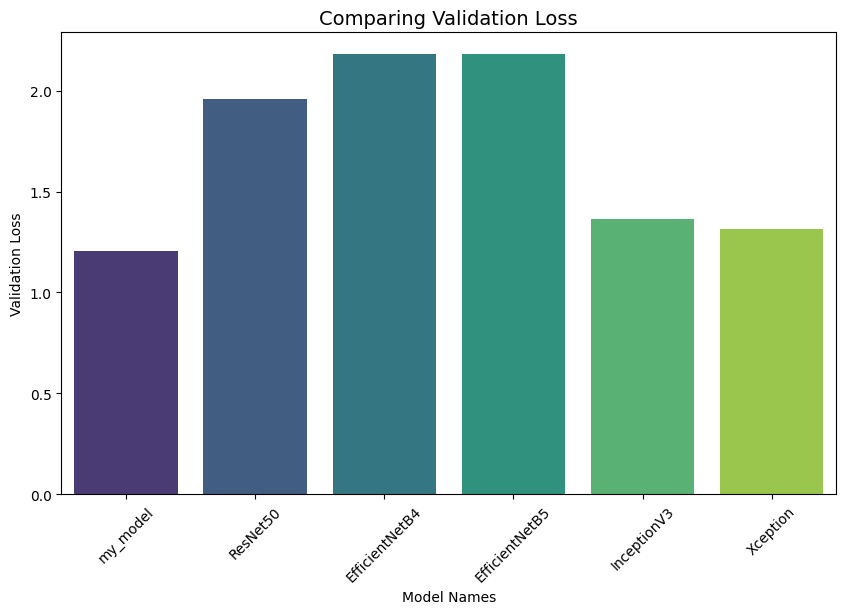

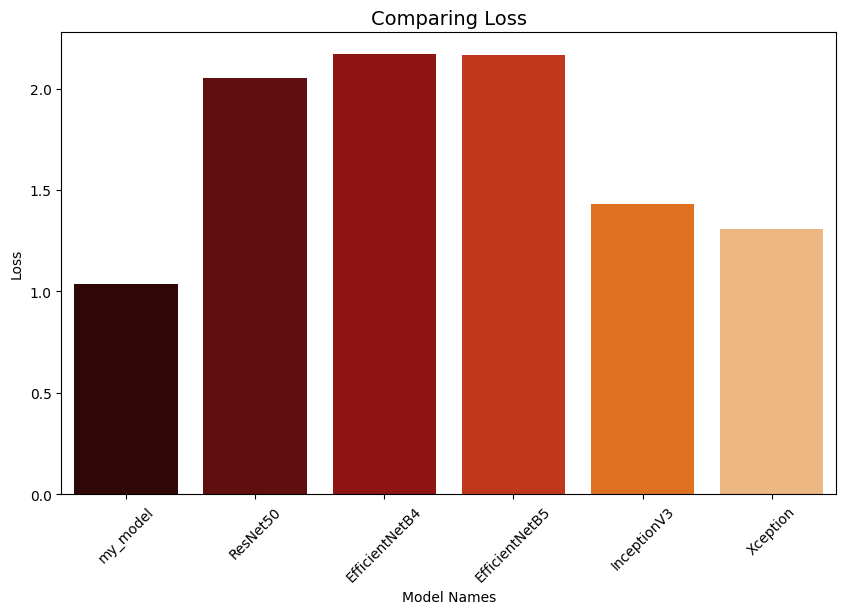

In [31]:
model_names = []
val_loss = []
loss = []

for model, history_entry in history_dict2.items():
    model_names.append(model if isinstance(model, str) else model.__name__)
    history_obj = history_entry[1]
    val_loss.append(min(history_obj.history.get('val_loss')))
    loss.append(min(history_obj.history.get('loss')))

plt.figure(figsize=(10, 6))
sb.barplot(x=model_names, y=val_loss, palette="viridis")
plt.xlabel("Model Names", fontsize=10)
plt.ylabel("Validation Loss", fontsize=10)
plt.title("Comparing Validation Loss", fontsize=14)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sb.barplot(x=model_names, y=loss, palette="gist_heat")
plt.xlabel("Model Names", fontsize=10)
plt.ylabel("Loss", fontsize=10)
plt.title("Comparing Loss", fontsize=14)
plt.xticks(rotation=45)
plt.show()

On comparision, we understand the top 3 models are :
1. my_model
2. Xception
3. InceptionV3

so we test and predict using all three models as each model have one or the other small error loss.

In [2]:
test_data = os.listdir('/kaggle/input/utkface-new/crop_part1')
test_df = pd.DataFrame(test_data,columns=['test_data'])
test_df['test_data'] = test_df['test_data'].astype('string')
test_df[['age','gender','ethnicity','date']] = test_df['test_data'].str.split('_',expand=True)

In [3]:
values_to_remove_test = [
    '20170109142408075.jpg.chip.jpg',
    '20170109150557335.jpg.chip.jpg',]

test_df.drop(test_df[test_df['ethnicity'].isin(values_to_remove_test)].index,inplace=True)
test_df.drop(columns={'date'},inplace=True)

In [4]:
test_df

,test_data,age,gender,ethnicity
0,26_0_2_20170104023102422.jpg.chip.jpg,26,0,2
1,21_1_3_20170105003215901.jpg.chip.jpg,21,1,3
2,17_1_4_20170103222931966.jpg.chip.jpg,17,1,4
3,76_0_0_20170104213515132.jpg.chip.jpg,76,0,0
4,18_1_0_20170104022856102.jpg.chip.jpg,18,1,0
...,...,...,...,...
9775,26_1_0_20170111182452795.jpg.chip.jpg,26,1,0
9776,66_0_0_20170104002319293.jpg.chip.jpg,66,0,0
9777,41_0_0_20170109012220690.jpg.chip.jpg,41,0,0
9778,2_0_2_20161219221701671.jpg.chip.jpg,2,0,2


In [5]:
X_test = []
for file in test_df['test_data']:
    img = load_img(f"/kaggle/input/utkface-new/crop_part1/{file}", target_size=(128,128))
    img_array = img_to_array(img) / 255
    X_test.append(img_array)

X_test = np.array(X_test)

In [6]:
y_test = test_df.iloc[:, 1:]
y_test

,age,gender,ethnicity
0,26,0,2
1,21,1,3
2,17,1,4
3,76,0,0
4,18,1,0
...,...,...,...
9775,26,1,0
9776,66,0,0
9777,41,0,0
9778,2,0,2


In [7]:
y_test1 = np.array(test_df['age']).astype(int)
y_test2 = np.array(test_df['gender']).astype(int)
y_test3 = np.array(test_df['ethnicity'].tolist(),dtype=int)

In [8]:
y_test1, y_test2, y_test3

(array([26, 21, 17, ..., 41,  2, 65]),
 array([0, 1, 1, ..., 0, 0, 1]),
 array([2, 3, 4, ..., 0, 2, 0]))

In [9]:
best_model_1 = load_model('/kaggle/working/my_model1.keras')
best_model_2 = load_model('/kaggle/working/<function Xception at 0x7bdc5381cb80>.keras')
best_model_3 = load_model('/kaggle/working/<function InceptionV3 at 0x7bdc537fdcf0>.keras')

In [17]:
age_pred, gender_pred, ethnicity_pred = best_model_1.predict(X_test)

age_pred = np.squeeze(age_pred)
gender_pred = np.squeeze(gender_pred)
ethnicity_pred = np.squeeze(ethnicity_pred)

age_pred = np.round(age_pred*100)
gender_pred = np.where(gender_pred <= 0.5 ,'0','1')
gender_pred = gender_pred.astype(np.int64)
ethnicity_pred = np.argmax(ethnicity_pred,axis=1)

age_mae = mean_absolute_error(y_test1, age_pred)
print("Age MAE:", age_mae)

gender_acc = accuracy_score(y_test2, gender_pred)
print("Gender Accuracy:", gender_acc)

ethnicity_acc = accuracy_score(y_test3, ethnicity_pred)
print("Ethnicity Accuracy:", ethnicity_acc)

306/306 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Age MAE: 15.411638371855185
Gender Accuracy: 0.8406627122110861
Ethnicity Accuracy: 0.721619963182655


***This model is best for it's Gender Accuracy ,moderately good for Ethnicity Accuracy , however needs improvement in the age feature prediction***

In [18]:
age_pred, gender_pred, ethnicity_pred = best_model_2.predict(X_test)

age_pred = np.squeeze(age_pred)
gender_pred = np.squeeze(gender_pred)
ethnicity_pred = np.squeeze(ethnicity_pred)

age_pred = np.round(age_pred*100)
gender_pred = np.where(gender_pred <= 0.5 ,'0','1')
gender_pred = gender_pred.astype(np.int64)
ethnicity_pred = np.argmax(ethnicity_pred,axis=1)

age_mae = mean_absolute_error(y_test1, age_pred)
print("Age MAE:", age_mae)

gender_acc = accuracy_score(y_test2, gender_pred)
print("Gender Accuracy:", gender_acc)

ethnicity_acc = accuracy_score(y_test3, ethnicity_pred)
print("Ethnicity Accuracy:", ethnicity_acc)

306/306 ━━━━━━━━━━━━━━━━━━━━ 25s 61ms/step
Age MAE: 10.760687257107794
Gender Accuracy: 0.8174473307424831
Ethnicity Accuracy: 0.6817345060339538


***This model is best for it's Gender Accuracy and Age Loss , however needs improvement in the Ethnicity feature prediction***

In [19]:
age_pred, gender_pred, ethnicity_pred = best_model_3.predict(X_test)

age_pred = np.squeeze(age_pred)
gender_pred = np.squeeze(gender_pred)
ethnicity_pred = np.squeeze(ethnicity_pred)

age_pred = np.round(age_pred*100)
gender_pred = np.where(gender_pred <= 0.5 ,'0','1')
gender_pred = gender_pred.astype(np.int64)
ethnicity_pred = np.argmax(ethnicity_pred,axis=1)

age_mae = mean_absolute_error(y_test1, age_pred)
print("Age MAE:", age_mae)

gender_acc = accuracy_score(y_test2, gender_pred)
print("Gender Accuracy:", gender_acc)

ethnicity_acc = accuracy_score(y_test3, ethnicity_pred)
print("Ethnicity Accuracy:", ethnicity_acc)

306/306 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step
Age MAE: 10.95408058907752
Gender Accuracy: 0.7712211086111679
Ethnicity Accuracy: 0.6826549396604623


***This model is best for it's Age Loss , moderately good in Gender Accuracy but needs improvement in the Ethnicity feature prediction***

# Predicted Results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted Age: 13
Actual Age: 7
------------------
Predicted Gender: Male
Actual Gender: Male
------------------
Predicted Ethnicity Class: 2
Actual Ethnictiy: 2


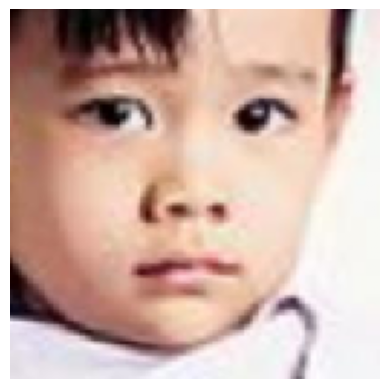

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted Age: 1
Actual Age: 1
------------------
Predicted Gender: Female
Actual Gender: Female
------------------
Predicted Ethnicity Class: 2
Actual Ethnictiy: 2


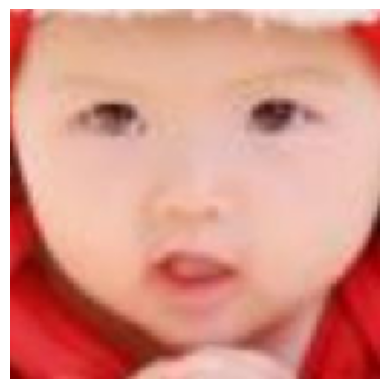

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Age: 56
Actual Age: 68
------------------
Predicted Gender: Male
Actual Gender: Male
------------------
Predicted Ethnicity Class: 0
Actual Ethnictiy: 0


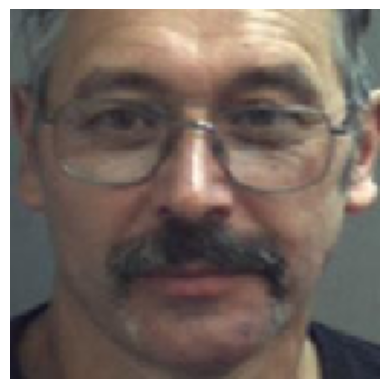

In [98]:
models_to_test = [best_model_1,best_model_2,best_model_3]
for i in range(3):
    rand_num = random.choice(range(len(X_test)))
    test_img = X_test[rand_num][None]
    
    age_pred, gender_pred, ethnicity_pred = models_to_test[i].predict(test_img)
    
    print(f"Predicted Age: {(age_pred*100).item():.0f}")
    print(f"Actual Age: {y_test1[rand_num]}")
    print('------------------')
    print(f"Predicted Gender: {'Male' if gender_pred <= 0.5 else 'Female'}")
    print(f"Actual Gender: {'Male' if y_test2[rand_num] == 0 else 'Female'}")
    print('------------------')
    print(f"Predicted Ethnicity Class: {np.argmax(ethnicity_pred)}")
    print(f"Actual Ethnictiy: {y_test3[rand_num]}")
    plt.imshow(X_test[rand_num])
    plt.axis(False)
    plt.show()